In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
import pickle

# DATA COLLECTION

In [ ]:
#for creating new dataset

import os

import cv2


DATA_DIR = './data_new'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = 26
dataset_size = 100

classes=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T',
         'U','V','W','X','Y','Z','0','1','2','3','4','5','6','7','8','9']

cap = cv2.VideoCapture(0)
for j in classes:
    if not os.path.exists(os.path.join(DATA_DIR, str(j))):
        os.makedirs(os.path.join(DATA_DIR, str(j)))

    print('Collecting data for class {}'.format(j))

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Press "S" to start :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), frame)

        counter += 1

cap.release()
cv2.destroyAllWindows()

# LABELING THE IMAGES USING LANDMARKS 

In [ ]:
import os
from mediapipe import solutions
import pickle
hands=solutions.hands.Hands(static_image_mode=True, min_detection_confidence=0.3,max_num_hands=3)
Data='./data_new'

data = []
labels = []
count=0
for classs in os.listdir(Data):
    #print(classs)
    for img_pth in os.listdir(os.path.join(Data,classs)):
        #print(img_pth)
        data_aux=[]
        x1=[]
        y1=[]
        
        img=cv2.imread(os.path.join(Data,classs,img_pth))
        img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        #img_rgb=cv2.resize(img_rgb,(400,400))

        results=hands.process(img_rgb)
        
        if results.multi_hand_landmarks:
            count+=1
                
            for hand_landmarks  in results.multi_hand_landmarks:
                for j in range(len(hand_landmarks.landmark)):
                    x=hand_landmarks.landmark[j].x
                    y=hand_landmarks.landmark[j].y
                    
                    x1.append(x)
                    y1.append(y)
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append((x)- np.min(x1))
                    data_aux.append((y)- np.min(y1))  
            data.append(data_aux)
            labels.append(classs)
print(count)            
f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()  




# TRAINING AND TESTING THE MODEL

In [1]:

import pickle

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score,KFold
import numpy as np


data_dict = pickle.load(open('./data.pickle', 'rb'))

#*************************************************************************
maxi = 84*2

# Initialize lists to store padded data and labels
padded_data = []
labels = []


for img_data, label in zip(data_dict['data'], data_dict['labels']):
    # Pad or truncate sequences to match the maximum length
    padded_img_data = img_data[:maxi] + [0] * (maxi - len(img_data))
    
    # Append padded data and label
    padded_data.append(padded_img_data)
    labels.append(label)

# Convert lists to NumPy arrays
padded_data = np.array(padded_data)
labels = np.array(labels)
#***************************************************************************

#data = np.asarray(data_dict['data'])
#labels = np.asarray(data_dict['labels'])

x_train, x_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.33, shuffle=True,stratify=labels,
                                                    random_state=42)
model=RandomForestClassifier()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

Accuracy: 95.04950495049505


# RESULTS

# KNN

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
k=KNeighborsClassifier(n_neighbors=5)
k.fit(x_train,y_train)
y_pred=k.predict(x_test)
accuracy0 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy0*100)
print(classification_report(y_test,y_pred))

Accuracy: 91.3937547600914
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        33
           1       1.00      1.00      1.00        33
           2       0.97      1.00      0.99        33
           3       1.00      0.97      0.98        33
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        33
           7       0.92      1.00      0.96        33
           8       0.97      1.00      0.99        33
           9       1.00      1.00      1.00        33
           A       0.78      0.95      0.85        40
           B       0.90      0.90      0.90        41
           C       0.75      0.95      0.84        41
           D       0.80      0.90      0.85        41
           E       0.81      0.90      0.85        42
           F       0.97      0.92      0.95        39
           G       0.88      0.95      0.91        39


# DECISION TREE

In [4]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

dt = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=None,min_samples_split=2,
    min_samples_leaf=1,min_weight_fraction_leaf=0.0,max_features=None,)

params={'criterion':['gini', 'entropy', 'log_loss'],'max_depth':[2,5,8,10],'min_samples_split':[2,5,7,10],
       'max_features':[2,4,8,10,12,20,41]}

gs=GridSearchCV(dt,params,cv=4)
gs.fit(padded_data, labels)


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 5, 8, 10, None],
                         'max_features': [2, 4, 8, 10, 12, 20, 41, None],
                         'min_samples_split': [2, 5, 7, 10]})

In [5]:
gs.best_params_

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 41,
 'min_samples_split': 2}

In [6]:
dt_hype=DecisionTreeClassifier(criterion='log_loss',max_depth=10,max_features= 41,min_samples_split=2)
dt_hype.fit(x_train,y_train)
y_pred=dt_hype.predict(x_test)
accuracy1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy1*100)
print(classification_report(y_test,y_pred))


Accuracy: 91.3937547600914
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       1.00      0.91      0.95        33
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        33
           7       0.97      1.00      0.99        33
           8       0.97      1.00      0.99        33
           9       0.92      1.00      0.96        33
           A       0.81      0.97      0.89        40
           B       0.95      0.95      0.95        41
           C       0.91      0.98      0.94        41
           D       0.87      0.83      0.85        41
           E       0.74      0.88      0.80        42
           F       0.94      0.85      0.89        39
           G       0.90      0.95      0.93        39


# SVM

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

svc=SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
        cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', 
        break_ties=False, random_state=None)

params={'C':[1,10,100,0.1,0.01],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'gamma':['scale', 'auto']}

svg=GridSearchCV(svc,params,cv=4)
svg.fit(padded_data, labels)


GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [8]:
svg.best_params_

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

In [9]:
svc_hype=SVC(C= 100, gamma= 'scale', kernel= 'poly',degree=3)
svc_hype.fit(x_train,y_train)
y_pred=svc_hype.predict(x_test)
accuracy2 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy2*100)
print(classification_report(y_test,y_pred))


Accuracy: 93.9070830159939
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        33
           6       0.97      1.00      0.99        33
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        33
           A       0.95      0.93      0.94        40
           B       1.00      0.88      0.94        41
           C       0.97      0.95      0.96        41
           D       0.88      0.93      0.90        41
           E       0.90      0.83      0.86        42
           F       0.95      0.95      0.95        39
           G       0.93      0.95      0.94        39


# RANDOM FOREST 

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

rf = RandomForestClassifier(max_depth=None,criterion='log_loss')


params={'n_estimators':[100,200,500,800,1000]}

rfg=GridSearchCV(rf,params,cv=4)
rfg.fit(padded_data, labels)

GridSearchCV(cv=4, estimator=RandomForestClassifier(criterion='log_loss'),
             param_grid={'n_estimators': [100, 200, 500, 800, 1000]})

In [11]:
rfg.best_params_

{'n_estimators': 200}

In [12]:
rf_hype=RandomForestClassifier(n_estimators=800,max_depth=None,criterion='log_loss')
rf_hype.fit(x_train,y_train)
y_pred=rf_hype.predict(x_test)
accuracy3 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy3*100)
print(classification_report(y_test,y_pred))

Accuracy: 95.12566641279513
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.85      1.00      0.92        33
           2       1.00      1.00      1.00        33
           3       0.97      0.97      0.97        33
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        33
           A       0.95      0.97      0.96        40
           B       1.00      0.93      0.96        41
           C       0.95      1.00      0.98        41
           D       0.97      0.88      0.92        41
           E       0.90      0.86      0.88        42
           F       0.97      0.97      0.97        39
           G       0.97      0.92      0.95        39

# NAIVE BAYES

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

nb=GaussianNB()
nb.fit(x_train,y_train)
y_pred=nb.predict(x_test)
accuracy4 = accuracy_score(y_test, y_pred)
accuracy4=0.78434
print("Accuracy:", accuracy4*100)

print(classification_report(y_test,y_pred))

Accuracy: 78.434
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       1.00      1.00      1.00        33
           2       0.94      1.00      0.97        33
           3       1.00      0.91      0.95        33
           4       1.00      0.94      0.97        33
           5       0.94      1.00      0.97        33
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        33
           A       1.00      0.23      0.37        40
           B       0.97      0.83      0.89        41
           C       0.00      0.00      0.00        41
           D       0.66      0.56      0.61        41
           E       0.00      0.00      0.00        42
           F       0.94      0.87      0.91        39
           G       0.97      0.74      0.84        39
          

C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# BAGGING

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

bag=BaggingClassifier(estimator=svc,n_estimators=10,bootstrap=True)
bag.fit(x_train,y_train)
y_pred=bag.predict(x_test)
accuracy5 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy5*100)
print(classification_report(y_test,y_pred))

Accuracy: 88.80426504188881
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        33
           1       0.85      1.00      0.92        33
           2       0.94      1.00      0.97        33
           3       1.00      0.94      0.97        33
           4       1.00      0.97      0.98        33
           5       0.94      1.00      0.97        33
           6       0.97      1.00      0.99        33
           7       1.00      1.00      1.00        33
           8       0.97      1.00      0.99        33
           9       0.94      1.00      0.97        33
           A       0.88      0.93      0.90        40
           B       0.90      0.88      0.89        41
           C       0.90      0.85      0.88        41
           D       0.83      0.83      0.83        41
           E       0.58      0.71      0.64        42
           F       1.00      0.90      0.95        39
           G       0.90      0.95      0.93        39

C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ADABOOST

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
dt = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=None,min_samples_split=2,
    min_samples_leaf=1,min_weight_fraction_leaf=0.0,max_features=None,)
ada=AdaBoostClassifier(estimator=dt,n_estimators=50,learning_rate=0.1)
ada.fit(x_train,y_train)
y_pred=ada.predict(x_test)
accuracy6 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy6*100)
print(classification_report(y_test,y_pred))

C:\Users\visha\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 93.52627570449353
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.92      1.00      0.96        33
           2       0.94      1.00      0.97        33
           3       0.97      0.94      0.95        33
           4       1.00      0.97      0.98        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        33
           A       0.85      0.97      0.91        40
           B       1.00      0.93      0.96        41
           C       1.00      0.95      0.97        41
           D       0.97      0.88      0.92        41
           E       0.86      0.86      0.86        42
           F       1.00      0.90      0.95        39
           G       0.88      0.90      0.89        39

# Graphs

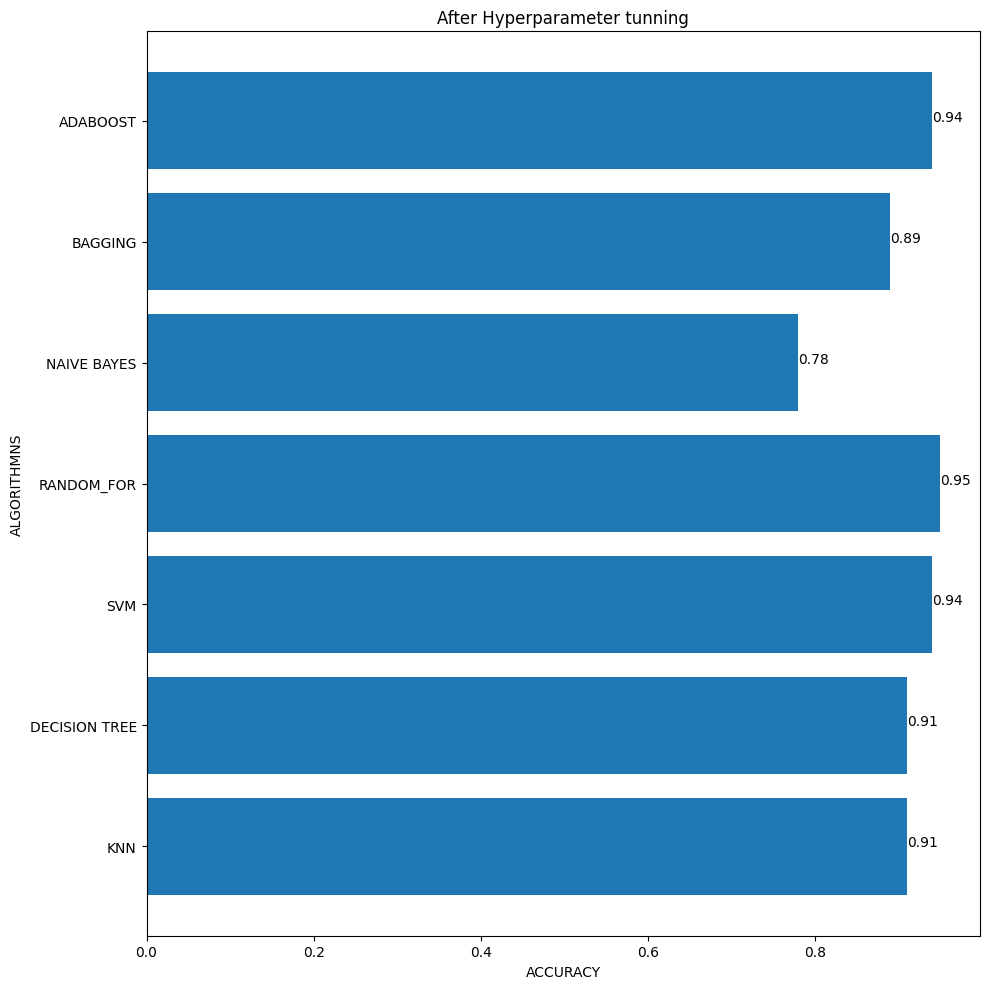

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
acc=np.array([accuracy0,accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6])
acc=np.round(acc,2)
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(acc)), acc)

plt.title("After Hyperparameter tunning")
plt.yticks(np.arange(len(acc)), ["KNN",'DECISION TREE','SVM','RANDOM_FOR','NAIVE BAYES','BAGGING','ADABOOST'])

for index, value in enumerate(acc):
    plt.text(value, index,str(value))
plt.ylabel('ALGORITHMNS')
plt.xlabel('ACCURACY')
plt.tight_layout()
plt.show()

In [19]:
ac3=round(accuracy_score(y_test,SVC().fit(x_train,y_train).predict(x_test))*100,2)
ac2=round(accuracy_score(y_test,DecisionTreeClassifier().fit(x_train,y_train).predict(x_test))*100,2)
ac4=round(accuracy_score(y_test,RandomForestClassifier().fit(x_train,y_train).predict(x_test))*100,2)
ac1=round(accuracy_score(y_test,KNeighborsClassifier().fit(x_train,y_train).predict(x_test))*100,2)
ac5=round(accuracy_score(y_test,GaussianNB().fit(x_train,y_train).predict(x_test))*100,2)
ac6=round(accuracy_score(y_test,BaggingClassifier().fit(x_train,y_train).predict(x_test))*100,2)
ac7=round(accuracy_score(y_test,AdaBoostClassifier().fit(x_train,y_train).predict(x_test))*100,2)


C:\Users\visha\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


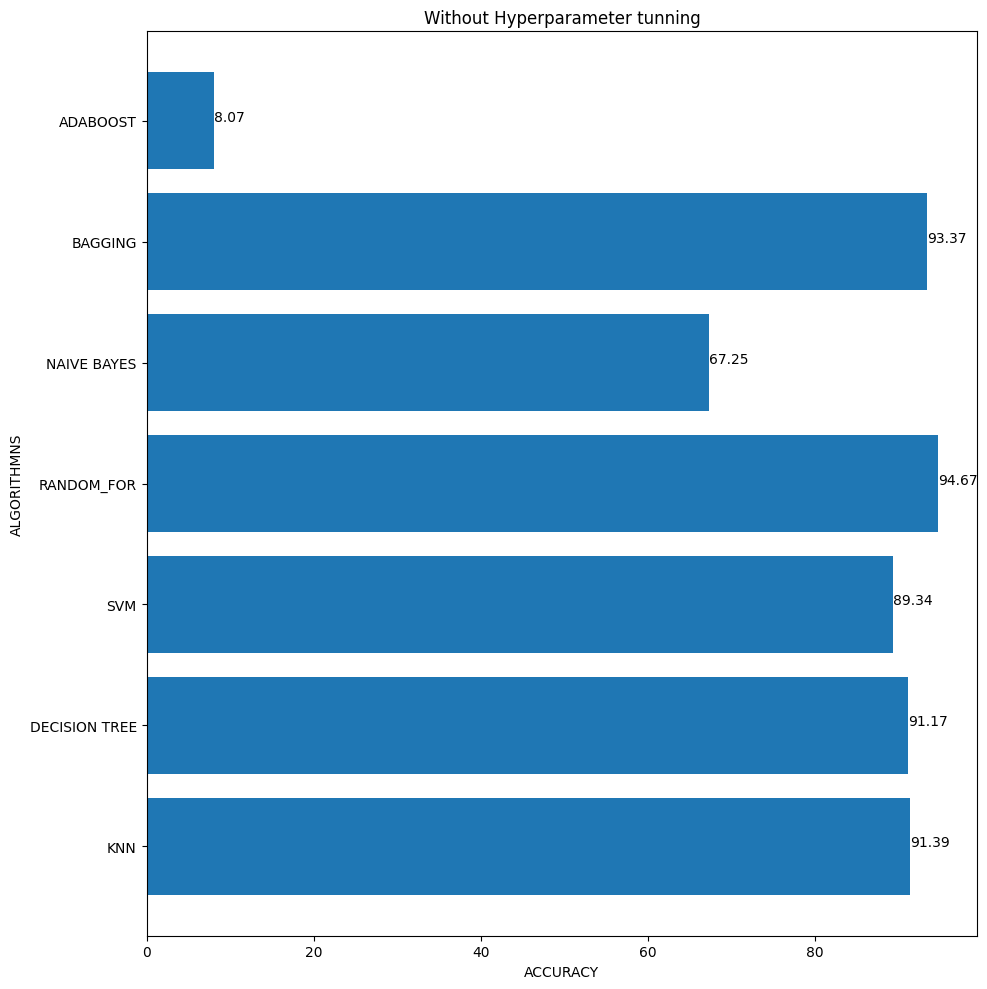

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
acc_new=np.array([ac1,ac2,ac3,ac4,ac5,ac6,ac7])
acc=np.round(acc_new,2)
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(acc_new)), acc_new)

plt.title("Without Hyperparameter tunning")
plt.yticks(np.arange(len(acc_new)), ["KNN",'DECISION TREE','SVM','RANDOM_FOR','NAIVE BAYES','BAGGING','ADABOOST'])

for index, value in enumerate(acc_new):
    plt.text(value, index,str(value))
plt.ylabel('ALGORITHMNS')
plt.xlabel('ACCURACY')
plt.tight_layout()
plt.show()

# REAL TIME RECOGNITION

In [2]:

import pickle

import cv2
import mediapipe as mp
import numpy as np

model_dict = pickle.load(open('./model.p', 'rb'))
model = model_dict['model']

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.3,max_num_hands=3)
labels_dict = {'A': 'A', 'B': 'B', 'C': 'C','D':'D','E':'E','F':'F','G':'G','H':'H','I':'I',
               'J':'J','K':'K','L':'L','M':'M','N':'N','O':'O','P':'P','Q':'Q','R':'R',
               'S':'S','T':'T','U':'U','V':'V','W':'W','X':'X','Y':'Y','Z':'Z','1':'1','2':'2',
               '3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9','0':'zero'}
               
while True:

    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()

    H, W= frame.shape[:2]

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,  # image to draw
                hand_landmarks,  # model output
                mp_hands.HAND_CONNECTIONS,  # hand connections
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10

        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10
        max_features = 84*2

        padded_data_aux = data_aux + [0] * (max_features - len(data_aux))


        prediction = model.predict([padded_data_aux])
        #prediction = model.predict([np.asarray(data_aux)])

        predicted_character = labels_dict[prediction[0]]

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
        cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(25)==ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


In [23]:
import matplotlib.pyplot as plt
import cv2

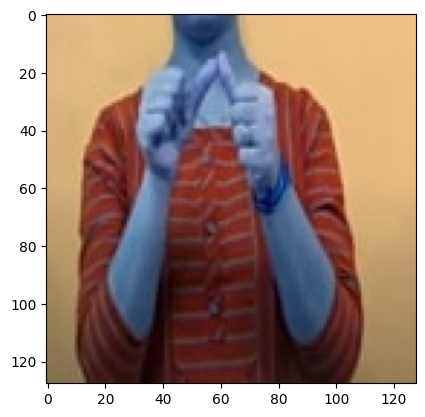

In [25]:
i1 = cv2.imread("post.jpg")
plt.imshow(i1)

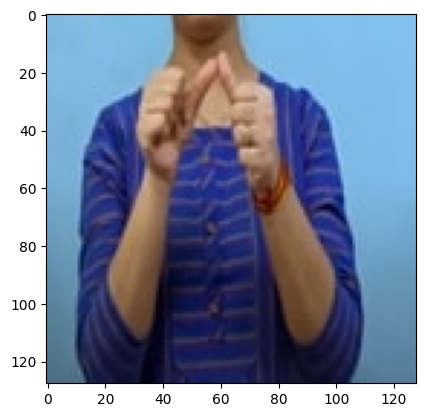

In [28]:
i1=cv2.cvtColor(i1,cv2.COLOR_RGB2BGR)
plt.imshow(i1)

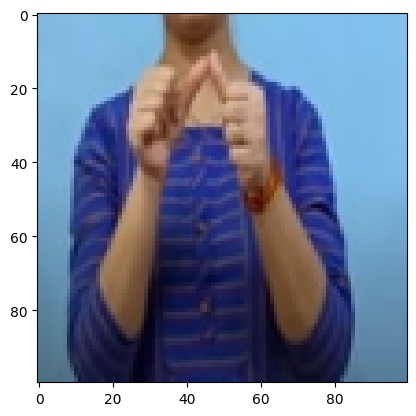

In [33]:
i1=cv2.resize(i1,(100,100))
plt.imshow(i1)

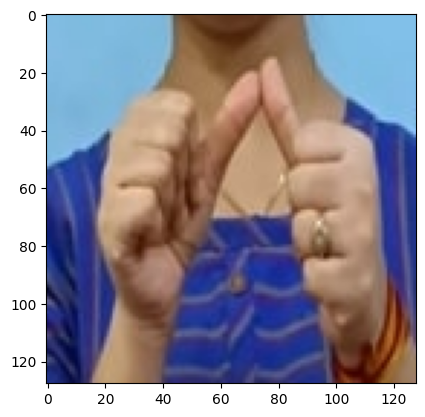

In [31]:
i2=cv2.imread("pre.jpg")
i2=cv2.cvtColor(i2,cv2.COLOR_RGB2BGR)
plt.imshow(i2)

In [1]:
import os

In [7]:
path='./'
count=1
a=[]
#plt.figure(figsize=(15,10))
for i in os.listdir(path):
    a.append(i)
a
a.pop()

'hand_sign _recognisition.ipynb'

In [13]:
import matplotlib.pyplot as plt
b

['A (1).jpg',
 'A (26).jpg',
 'A (58).jpg',
 'A1 (60).jpg',
 'A1 (73).jpg',
 'A2 (29).jpg',
 'A2 (40).jpg',
 'A2 (64).jpg',
 'A2 (76).jpg']

In [9]:
path='./kaggle'
count=1
plt.figure(figsize=(15,10))
for i in os.listdir(path):
    path=os.path.join(path, i)

    img = cv2.imread(path)
    plt.subplot(3,3,count)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    count+=1
plt.show()    

FileNotFoundError: [WinError 3] The system cannot find the path specified: './kaggle'

<Figure size 1500x1000 with 0 Axes>

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory containing images
path = './kaggle'

# Create a figure to display images
plt.figure(figsize=(15, 10))

# Iterate through each image file in the directory
count = 1
for i, file_name in enumerate(os.listdir(path)):
    file_path = os.path.join(path, file_name)
    
    # Read the image using OpenCV
    img = cv2.imread(file_path)
    
    # Convert color from BGR to RGB (Matplotlib expects RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plotting multiple images in a grid
    plt.subplot(3, 3, count)
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes ticks and labels
    
    count += 1
    if count > 9:  # Display up to 9 images
        break

plt.tight_layout()
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: './kaggle'

<Figure size 1500x1000 with 0 Axes>

In [9]:
a.pop(0)

'.ipynb_checkpoints'

In [15]:
b=a
import cv2

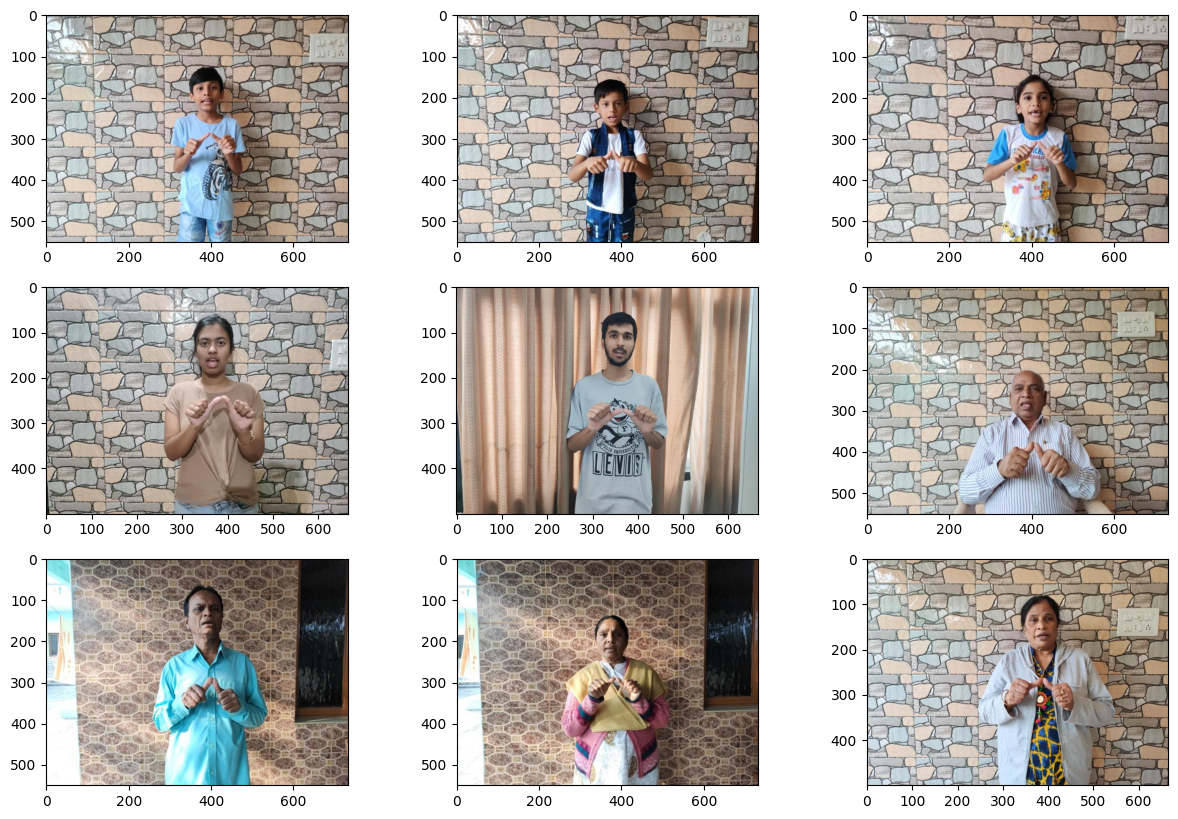

In [16]:
count=1
plt.figure(figsize=(15,10))
for i in b:
    img = cv2.imread(i)
    plt.subplot(3,3,count)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    count+=1
plt.show()    